In [7]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
# pool.close()

In [8]:
FillVar = 'fco2'

FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD','Temp','VWC','Sedge','Shurb','Out_of_Basin']
print(len(FullModel))
Runs,params = Dense.Params('Full',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
Runs['CI'] = 0.0
print(Runs)

11
     N  MSE  STD   CI
0    5  0.0  0.0  0.0
1   53  0.0  0.0  0.0
2  101  0.0  0.0  0.0
3  150  0.0  0.0  0.0


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.148056887042
Finisehed Run  1  MSE:  0.111017386762
Finisehed Run  2  MSE:  0.106611905347
Finisehed Run  3  MSE:  0.0990521019495


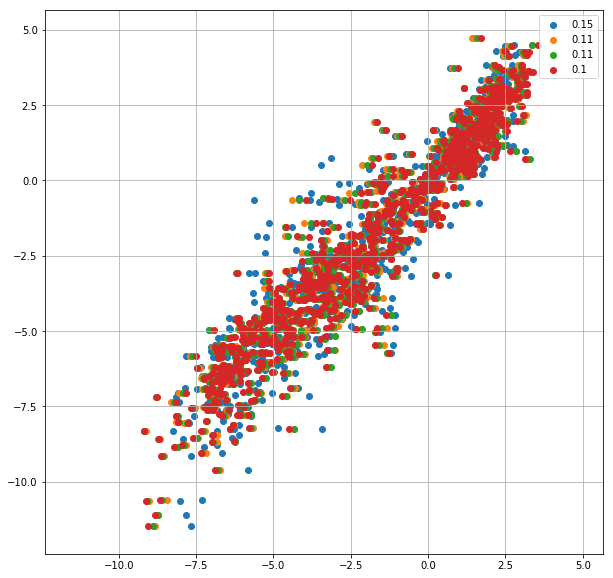

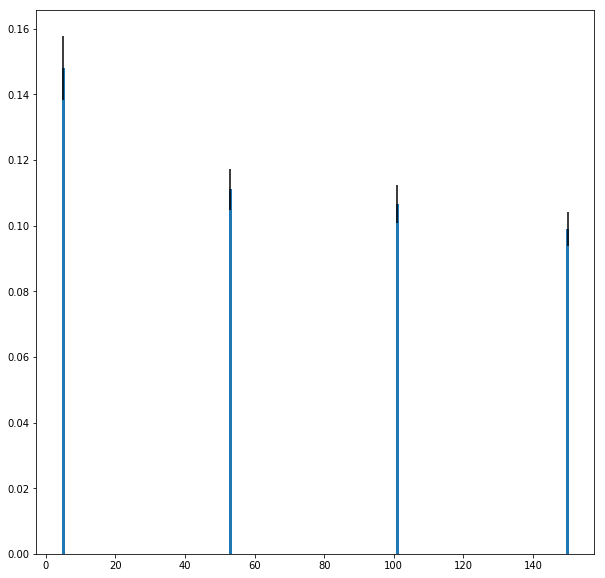

In [9]:

def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


# AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
#          'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

# FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','Rain','Water Table']


FullModel = ['wind_speed','Sedge','Shrub','PPFD_Avg','Temp','AirTC_Avg','u*','air_pressure','VWC','Z_L','VPD']



Time = time.time()
Path = 'Data_Footprints_2018-05-10.csv'

plt.figure(figsize=(10,10))
def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
#     STD = []
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
#             mse = results[0]
#             y_fill = results[1]
            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
#             Y_fill.append(y_fill)
#             MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Yval.append(results[2])
            y_val.append(results[3])
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)
    
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        
#         plt.scatter(y_val,Yval,label=np.round(MSE.mean(),2))
        plt.scatter(RST.Master['TempFill'],RST.Master[FillVar],label=np.round(MSE.mean(),2))
        yl = plt.ylim()
        plt.xlim(yl)
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

plt.grid()
plt.legend()
Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    

In [10]:
def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf
    for N in np.linspace(1,params['N_Max']):
        if params['T']>0:
            for T in np.linspace(0,params['T_Max']):
                def obj(x):
                    x=x.reshape(1,-1)
                    mu_x, sigma_x = gp.predict(x, return_std=True)
                    return acq(mu_x, sigma_x, np.min(yi))
                x0 = np.asanyarray([N,T]).reshape(1,2)
                bounds=((1, params['N_Max']),(0,params['T_Max']))
                print(x0,bounds)
                res = minimize(obj, x0, bounds=bounds)

                if res.fun < best_value:
                    best_value = res.fun
                    query_point = res.x
        else:
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray(N).reshape(1,-1)
            bounds=[(1, params['N_Max'])]
            res = minimize(obj, x0, bounds=bounds)
            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point


params['T']=0
for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    if params['T']>0:
        gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
        next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        T = int(np.round(next_x[1],0))
        o = 0
        while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
            if o > 5:
                T += 1
        print(N,T)
        d = {'N':N,'T':T,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['T'] = T
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    else:
        gp.fit(Runs['N'].values.reshape(-1,1), Runs['MSE'].values)
        next_x = query(Runs['N'].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        o = 0
        while len(Runs.loc[Runs['N']==N].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
        print(N)
        d = {'N':N,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N']).reset_index(drop=True)
        

# plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

147


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


143
139


         CI       MSE    N       STD  Upper_Bounds
0  0.009689  0.148057    5  0.031231      0.157745
1  0.006363  0.111017   53  0.020511      0.117380
2  0.005737  0.106612  101  0.018492      0.112349
3  0.005265  0.101152  139  0.016973      0.106417
4  0.005132  0.102058  143  0.016545      0.107191
5  0.005256  0.101085  147  0.016943      0.106341
6  0.005239  0.099052  150  0.016889      0.104291
Optimum:
         CI       MSE    N       STD  Upper_Bounds
3  0.005265  0.101152  139  0.016973      0.106417


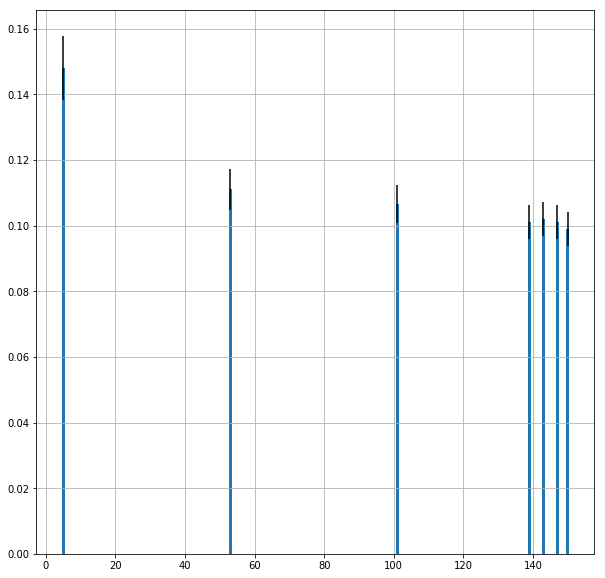

In [ ]:
try:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    
plt.grid()
print(Runs)
Optimum = Runs[Runs['MSE'] <= Runs['Upper_Bounds'].min()]
# print(Optimum)
Optimum = Optimum[Optimum['N'] == Optimum['N'].min()]

print('Optimum:')
print(Optimum)


# Feature Identification

In [ ]:
BestMSE = []
BestSTD = []
idx = []
BestModels = []

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
params['N']=Optimum['N'].values[0]
# print(Optimum)

print(FullModel)
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
# print(Scores)
Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})
# print(ModelRuns)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     Score = []
#     STD = []
#     Model_Names = []
    
    for i,model in enumerate(Models):
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+'+'.join(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
        level = len(model)
        key = str(level)+'_'+str(i)
        d = {'Model':'+'.join(model),
             'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+CI,
                'Key':key}
        score = pd.DataFrame(index=[0],data=d)
        print(model,' Upper Bound ',mean+CI)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]
        
    Level = Scores.loc[Scores['Level'] == level]
    Lowest_Yet = Scores.loc[Scores['Level']<= level]['Upper_Bounds'].min()
    Best = Level.loc[Level['MSE']<=Lowest_Yet]['Model'].values
    print(Best)
#     print(ModelRuns)
#         print(model,MSE)
#         Score.append(MSE.mean())
#         STD.append(MSE.std())
#         Model_Names.append('Model: '+'+'.join(model))
        
#     Score = np.asanyarray(Score)
#     STD = np.asanyarray(STD)
#     Best = Models[np.where(Score == Score.min())[0][0]]
#     Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
#     BestModels.append(Best_Name)
#     BestMSE.append(Score.min())
#     BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
#     idx.append(i)
#     print('Best:')
#     print(Best,Score.min())
# BestModels = np.asanyarray(BestModels)
# BestMSE = np.asanyarray(BestMSE)
# BestSTD = np.asanyarray(BestSTD)
# idx = np.asanyarray(idx)
# BestSE = BestSTD/(params['reps']**.5)
# BestCI = BestSE*1.96
# plt.figure(figsize=(10,10))
# plt.bar(idx,BestMSE)
# plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

# d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
# Stats = pd.DataFrame(index=idx,data=d)
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

ModelRuns.to_csv('GapFilled'+FillVar+'.csv')



['wind_speed', 'Sedge', 'Shrub', 'PPFD_Avg', 'Temp', 'AirTC_Avg', 'u*', 'air_pressure', 'VWC', 'Z_L', 'VPD']


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Level:  1
[['wind_speed'], ['Sedge'], ['Shrub'], ['PPFD_Avg'], ['Temp'], ['AirTC_Avg'], ['u*'], ['air_pressure'], ['VWC'], ['Z_L'], ['VPD']]
['wind_speed']  Upper Bound  0.986040378996
['Sedge']  Upper Bound  0.978042904762
['Shrub']  Upper Bound  0.990350007789
['PPFD_Avg']  Upper Bound  0.15304697796
['Temp']  Upper Bound  0.894362886175
['AirTC_Avg']  Upper Bound  0.86130880531
['u*']  Upper Bound  0.985683717424


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['air_pressure']  Upper Bound  0.98254705494
['VWC']  Upper Bound  0.987350878772
['Z_L']  Upper Bound  0.547818353661
['VPD']  Upper Bound  0.747180484827
['PPFD_Avg']
Level:  2
[['wind_speed', 'PPFD_Avg'], ['Sedge', 'PPFD_Avg'], ['Shrub', 'PPFD_Avg'], ['PPFD_Avg', 'Temp'], ['PPFD_Avg', 'AirTC_Avg'], ['PPFD_Avg', 'u*'], ['PPFD_Avg', 'air_pressure'], ['PPFD_Avg', 'VWC'], ['PPFD_Avg', 'Z_L'], ['PPFD_Avg', 'VPD']]
['wind_speed', 'PPFD_Avg']  Upper Bound  0.147273122196
['Sedge', 'PPFD_Avg']  Upper Bound  0.153686695492
['Shrub', 'PPFD_Avg']  Upper Bound  0.152058290172


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['PPFD_Avg', 'Temp']  Upper Bound  0.152679272271
['PPFD_Avg', 'AirTC_Avg']  Upper Bound  0.152536422164
['PPFD_Avg', 'u*']  Upper Bound  0.148632290721
['PPFD_Avg', 'air_pressure']  Upper Bound  0.147953696057
['PPFD_Avg', 'VWC']  Upper Bound  0.151902168181
['PPFD_Avg', 'Z_L']  Upper Bound  0.149989651663
['PPFD_Avg', 'VPD']  Upper Bound  0.150773744545
['wind_speed+PPFD_Avg' 'Sedge+PPFD_Avg' 'Shrub+PPFD_Avg' 'PPFD_Avg+Temp'
 'PPFD_Avg+AirTC_Avg' 'PPFD_Avg+u*' 'PPFD_Avg+air_pressure' 'PPFD_Avg+VWC'
 'PPFD_Avg+Z_L' 'PPFD_Avg+VPD']
Level:  3
[['wind_speed', 'Sedge', 'PPFD_Avg'], ['wind_speed', 'Shrub', 'PPFD_Avg'], ['wind_speed', 'PPFD_Avg', 'Temp'], ['wind_speed', 'PPFD_Avg', 'AirTC_Avg'], ['wind_speed', 'PPFD_Avg', 'u*'], ['wind_speed', 'PPFD_Avg', 'air_pressure'], ['wind_speed', 'PPFD_Avg', 'VWC'], ['wind_speed', 'PPFD_Avg', 'Z_L'], ['wind_speed', 'PPFD_Avg', 'VPD'], ['Sedge', 'Shrub', 'PPFD_Avg'], ['Sedge', 'PPFD_Avg', 'Temp'], ['Sedge', 'PPFD_Avg', 'AirTC_Avg'], ['Sedge', 'PPFD_Av

Using TensorFlow backend.
Using TensorFlow backend.


['wind_speed', 'Sedge', 'PPFD_Avg']  Upper Bound  0.138127774332


Using TensorFlow backend.


['wind_speed', 'Shrub', 'PPFD_Avg']  Upper Bound  0.144148492423
['wind_speed', 'PPFD_Avg', 'Temp']  Upper Bound  0.146386943551
['wind_speed', 'PPFD_Avg', 'AirTC_Avg']  Upper Bound  0.142031343432
['wind_speed', 'PPFD_Avg', 'u*']  Upper Bound  0.146508925116
['wind_speed', 'PPFD_Avg', 'air_pressure']  Upper Bound  0.143849524211
['wind_speed', 'PPFD_Avg', 'VWC']  Upper Bound  0.145972549124
['wind_speed', 'PPFD_Avg', 'Z_L']  Upper Bound  0.147698427732


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['wind_speed', 'PPFD_Avg', 'VPD']  Upper Bound  0.138014885548
['Sedge', 'Shrub', 'PPFD_Avg']  Upper Bound  0.153877914305
['Sedge', 'PPFD_Avg', 'Temp']  Upper Bound  0.149358083524
['Sedge', 'PPFD_Avg', 'AirTC_Avg']  Upper Bound  0.149514675994
['Sedge', 'PPFD_Avg', 'u*']  Upper Bound  0.140918031983
['Sedge', 'PPFD_Avg', 'air_pressure']  Upper Bound  0.135962709013
['Sedge', 'PPFD_Avg', 'VWC']  Upper Bound  0.13678809536


Using TensorFlow backend.
Using TensorFlow backend.


['Sedge', 'PPFD_Avg', 'Z_L']  Upper Bound  0.144482976132


Using TensorFlow backend.


['Sedge', 'PPFD_Avg', 'VPD']  Upper Bound  0.147944389105
['Shrub', 'PPFD_Avg', 'Temp']  Upper Bound  0.140521915063
['Shrub', 'PPFD_Avg', 'AirTC_Avg']  Upper Bound  0.148698407436
['Shrub', 'PPFD_Avg', 'u*']  Upper Bound  0.145546779114
['Shrub', 'PPFD_Avg', 'air_pressure']  Upper Bound  0.143829188009
['Shrub', 'PPFD_Avg', 'VWC']  Upper Bound  0.137905791597
['Shrub', 'PPFD_Avg', 'Z_L']  Upper Bound  0.147627298807


Using TensorFlow backend.
Using TensorFlow backend.


['Shrub', 'PPFD_Avg', 'VPD']  Upper Bound  0.146714047598


Using TensorFlow backend.


['PPFD_Avg', 'Temp', 'AirTC_Avg']  Upper Bound  0.145858865104
['PPFD_Avg', 'Temp', 'u*']  Upper Bound  0.147844614797
['PPFD_Avg', 'Temp', 'air_pressure']  Upper Bound  0.140202551077
['PPFD_Avg', 'Temp', 'VWC']  Upper Bound  0.14963152328
['PPFD_Avg', 'Temp', 'Z_L']  Upper Bound  0.151526747764
['PPFD_Avg', 'Temp', 'VPD']  Upper Bound  0.137155215002


Using TensorFlow backend.
Using TensorFlow backend.


['PPFD_Avg', 'AirTC_Avg', 'u*']  Upper Bound  0.143514682165


Using TensorFlow backend.


['PPFD_Avg', 'AirTC_Avg', 'air_pressure']  Upper Bound  0.132500363405
['PPFD_Avg', 'AirTC_Avg', 'VWC']  Upper Bound  0.139843267201
['PPFD_Avg', 'AirTC_Avg', 'Z_L']  Upper Bound  0.149866752006
['PPFD_Avg', 'AirTC_Avg', 'VPD']  Upper Bound  0.142003438767
['PPFD_Avg', 'u*', 'air_pressure']  Upper Bound  0.143294654205
['PPFD_Avg', 'u*', 'VWC']  Upper Bound  0.145613345595
['PPFD_Avg', 'u*', 'Z_L']  Upper Bound  0.148010888572


Using TensorFlow backend.
Using TensorFlow backend.


['PPFD_Avg', 'u*', 'VPD']  Upper Bound  0.139019203123


Using TensorFlow backend.


In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        